In [1]:
from pathlib import Path
import networkx as nx
from src import thinning as th
from src import extract_branches_functions as eb
from src import Measure as M
import scipy.sparse
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio.v2 as imageio
from skimage import io
import seaborn as sns
import csv
import pickle
import re
import ast
from glob import glob
import functools
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
%load_ext autoreload
%autoreload 2

# Graph creation from CSV data

In [2]:
sns.set_theme(style="darkgrid")

# Set global font color to white
plt.rcParams.update({
    'text.color': 'white',       # General text color
    'axes.labelcolor': 'white',  # X and Y axis labels
    'xtick.color': 'white',      # X-axis tick labels
    'ytick.color': 'white',      # Y-axis tick labels
    'axes.edgecolor': 'white',   # Axes border color
    'axes.titlecolor': 'white',  # Title color
    'font.size': 14,             # General font size
    'axes.titlesize': 16,        # Title font size
    'axes.labelsize': 14,        # X and Y label font size
    'xtick.labelsize': 12,       # X-axis tick font size
    'ytick.labelsize': 12        # Y-axis tick font size
})

path_csv = fr'E:\Jurr\notebooks\Growth_tracking\Growth_processed\**\csv\*.csv'
files = glob(path_csv)
#print(files)

In [3]:
df_list = []
for file in files:
    chip_id, *extras = Path(file).stem.split('+')
    plant_hormone, plant_extract = (extras + [' + None', ' + None'])[:2]
    
    data = pd.read_csv(file)
    data['id'], data['plant_hormone'], data['plant_extract'] = chip_id, plant_hormone, plant_extract
    df_list.append(data)
    
merged_df = pd.concat(df_list, ignore_index=True)
merged_df['day'] = (
    merged_df.iloc[:, 0]
    .astype(str)                               
    .str.strip()                               
    .str.replace('Day', '', regex=False)       
    .astype(int)                               
)
merged_df

C:\Users\stanl\AppData\Local\Temp\ipykernel_11168\63900047.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged_df = pd.concat(df_list, ignore_index=True)


,day,number of tips,total_length_um,all_branches_lengths_um,tips_total_length_um,tips_lengths_um,other_total_length_um,other_lengths_um,id,plant_hormone,plant_extract
0,0,62,2958.196640,"[4.628660713424565, 29.946556208168246, 42.366...",1171.390816,4.628660713424565;25.31789549474368;12.4199999...,1786.805823,12.591318437717312;15.76465032913829;34.031434...,G41A_C2_pMyr (0.5 mM),+ None,+ None
1,7,95,4038.238383,"[39.06712312508046, 45.27712312508046, 54.5344...",1537.901909,39.06712312508046;24.92610077810005;17.8068133...,2500.336474,6.209999999999999;9.25732142684913;14.48999999...,G41A_C2_pMyr (0.5 mM),+ None,+ None
2,8,113,4324.941412,"[4.14, 6.209999999999999, 10.349999999999998, ...",1454.073533,4.14;2.07;4.14;8.28;4.14;4.14;2.07;4.14;49.691...,2870.867879,8.534828645028556;6.545914756548545;7.46349114...,G41A_C2_pMyr (0.5 mM),+ None,+ None
3,9,88,4064.542537,"[93.95130612468262, 140.51320130279984, 174.61...",1499.592330,93.95130612468262;46.56189517811722;34.1001617...,2564.950207,20.387135649717933;15.76465032913829;9.2573214...,G41A_C2_pMyr (0.5 mM),+ None,+ None
4,10,74,3798.678944,"[94.4940360628142, 138.67923299037753, 175.570...",1313.428043,94.4940360628142;44.18519692756333;36.89127032...,2485.250901,12.419999999999998;6.545914756548545;37.492116...,G41A_C2_pMyr (0.5 mM),+ None,+ None
...,...,...,...,...,...,...,...,...,...,...,...
465,10,714,104954.909241,"[48.304879919363565, 55.76837105957402, 128.75...",21485.229366,48.304879919363565;7.463491140210457;13.885982...,83469.679875,72.98962457064432;48.04915729226878;171.977880...,G73B_09_MSR_pMyr0.5mM,+ None,+ None
466,12,874,111640.370229,"[4.14, 14.489999999999998, 22.769999999999996,...",23861.908612,6.209999999999999;15.76465032913829;10.35;16.6...,87778.461618,4.14;10.35;8.28;66.40341311460658;19.084457026...,G73B_09_MSR_pMyr0.5mM,+ None,+ None
467,0,80,3195.207923,"[19.52834094335717, 50.5896214176214, 87.36016...",1092.094600,19.52834094335717;8.28;26.909999999999997;14.4...,2103.113323,31.06128047426423;36.77054477940356;26.2400951...,G73C_09_MSR_pMyr0.5mM,+ None,+ None
468,3,71,4277.589428,"[17.069657290057112, 19.139657290057112, 23.76...",1279.822510,17.069657290057112;26.909999999999997;2.927422...,2997.766918,2.07;4.628660713424565;4.14;17.069657290057112...,G73C_09_MSR_pMyr0.5mM,+ None,+ None


In [4]:
#Create 3 dfs based on strain, C2 df only contain 0.5mM
strain_filter =  ~merged_df['id'].str.contains("D197198|A1|0.25mM|A5|Ctrl|09",regex = True)
df_filtered = merged_df[strain_filter].copy()

strain_filter_D197198 = merged_df['id'].str.contains("D197198", regex = True)
df_filtered_D197198 = merged_df[strain_filter_D197198].copy()

strain_filter_09 = merged_df['id'].str.contains("09", regex = True)
df_filtered_09 = merged_df[strain_filter_09].copy()


In [5]:
#df_filtered

In [5]:
dfs = [df_filtered, df_filtered_D197198, df_filtered_09]

# Create new columns where starting size is subtracted and length from um to mm
cols = [
    ('total_length_um', 'length_increase_mm', 1000),
    ('number of tips', 'tips_increase', 1),
    ('tips_total_length_um', 'tips_total_length_increase_mm', 1000)
]

for df in dfs:
    for col, new_col, divisor in cols:
        df[new_col] = df.groupby('id')[col].transform(lambda x: (x - x.iloc[0]) / divisor)

In [6]:
#Removal of abnormalities / manual filtering of datapoints (Based on excell file comments)

#C2
excluded_datapoints = []

subset = df_filtered[df_filtered["id"].str.contains("G48A")]
excluded_datapoints.extend(subset.iloc[[5]].index.tolist())

subset = df_filtered[df_filtered["id"].str.contains("G48B")]
excluded_datapoints.extend(subset.iloc[[-2]].index.tolist())

subset = df_filtered[df_filtered["id"].str.contains("G48C")]
excluded_datapoints.extend(subset.iloc[6:].index.tolist())


subset = df_filtered[df_filtered["id"].str.contains("G63A")]
subset
excluded_datapoints.extend(subset.iloc[7:].index.tolist())


#D197198
excluded_datapoints_D197198 = []

subset = df_filtered_D197198[df_filtered_D197198["id"].str.contains("G62C")]
excluded_datapoints_D197198.extend(subset.iloc[7:].index.tolist())

#09 not needed

In [7]:
# Check the excluded rows C2
df_filtered.loc[excluded_datapoints]

,day,number of tips,total_length_um,all_branches_lengths_um,tips_total_length_um,tips_lengths_um,other_total_length_um,other_lengths_um,id,plant_hormone,plant_extract,length_increase_mm,tips_increase,tips_total_length_increase_mm
212,14,329,29187.517505,"[2.07, 12.42, 24.129688296449228, 30.675603052...",6144.136736,2.07;10.35;12.070070422329772;8.28;14.48999999...,23043.380769,11.709688296449228;6.545914756548545;2.07;4.62...,G48A_C2_MSR_pMyr0.5mM,+ None,+ None,25.975396,276.0,5.072933
225,24,990,127903.649820,"[4.14, 8.768660713424564, 37.34209263990915, 4...",25366.263561,4.14;28.573431926484584;11.709688296449228;19....,102537.386259,4.628660713424565;8.28;21.698318003481678;33.2...,G48B_C2_MSR_pMyr0.5mM,+ None,+ None,125.408069,945.0,24.602076
233,17,278,49796.783668,"[np.float64(6.209999999999999), np.float64(325...",13220.069598,6.209999999999999;748.4371496812729;56.2988857...,36576.714070,318.9864850714405;175.95;275.6197276071607;6.5...,G48C_C2_MSR_pMyr0.5mM,+ None,+ None,42.690648,163.0,12.098642
234,19,284,48440.542573,"[np.float64(278.7147127925922), np.float64(520...",12899.658581,278.7147127925922;55.54910735573456;54.2823935...,35540.883992,241.62818069619027;102.80901597390566;108.0583...,G48C_C2_MSR_pMyr0.5mM,+ None,+ None,41.334407,169.0,11.778231
235,24,221,38928.269019,"[np.float64(123.78673387013745), np.float64(13...",8215.861393,123.78673387013745;517.4604488379252;2.9274220...,30712.407626,14.637110370561533;45.769294471888905;845.2079...,G48C_C2_MSR_pMyr0.5mM,+ None,+ None,31.822133,106.0,7.094433
236,26,17,6039.770357,"[np.float64(852.9006201974811), np.float64(138...",5111.646387,852.9006201974811;528.2576808647882;4.62866071...,928.123970,8.534828645028556;2.07;2.07;821.2095646209901;...,G48C_C2_MSR_pMyr0.5mM,+ None,+ None,-1.066366,-98.0,3.990218
365,15,816,71311.727977,"[3034.62, 7159.092425357203, 7165.638340113752...",17166.852067,3034.62;4124.472425357203;6.209999999999999;8....,54144.875911,6.545914756548545;11.147291150768423;12.591318...,G63A_C2_MSR_pMyr0.5mM,+ None,+ None,69.532354,797.0,16.488787
366,18,853,67917.756369,"[549.0646980002977, 1108.5841532146192, 1120.6...",11207.363765,549.0646980002977;12.070070422329772;6.2099999...,56710.392604,559.5194552143215;2952.1978035091574;14.489999...,G63A_C2_MSR_pMyr0.5mM,+ None,+ None,66.138382,834.0,10.529299
367,21,636,63813.183886,"[3970.2599999999998, 11412.824497905422, 11423...",19170.595882,3970.2599999999998;7442.564497905422;10.35;165...,44642.588003,426.9362126786012;409.9632425357202;4.14;1037....,G63A_C2_MSR_pMyr0.5mM,+ None,+ None,62.033809,617.0,18.492531
368,24,470,52827.847972,"[1111.7964850714404, 6179.1009848340655, 6197....",9146.908535,1111.7964850714404;1261.1462126786014;10.55497...,43680.939437,5067.304499762625;18.63;640.4673449859862;47.6...,G63A_C2_MSR_pMyr0.5mM,+ None,+ None,51.048474,451.0,8.468843


In [8]:
# Check the excluded rows D197198
df_filtered_D197198.loc[excluded_datapoints_D197198]

,day,number of tips,total_length_um,all_branches_lengths_um,tips_total_length_um,tips_lengths_um,other_total_length_um,other_lengths_um,id,plant_hormone,plant_extract,length_increase_mm,tips_increase,tips_total_length_increase_mm
353,15,1328,102475.953469,"[170.04972760716072, 340.27838832058524, 350.6...",19594.172920,170.04972760716072;10.35;6.209999999999999;6.2...,82881.780549,170.22866071342455;4.14;261.02648507144045;47....,G62C_D197198_MSR_pMyr0.5mM,+ None,+ None,98.533912,1279.0,18.614958
354,16,1124,94979.539533,"[5907.98648507144, 6802.536212678601, 6817.026...",24552.844569,5907.98648507144;894.5497276071609;18.63;14.63...,70426.694964,14.489999999999998;44.73736286038643;44.596087...,G62C_D197198_MSR_pMyr0.5mM,+ None,+ None,91.037498,1075.0,23.573630
355,17,2522,178868.569679,"[2446.74, 6276.24, 6874.469999999999, 7049.713...",38476.034408,2446.74;3829.4999999999995;598.2299999999999;1...,140392.535271,752.0892034881338;14.489999999999998;14.489999...,G62C_D197198_MSR_pMyr0.5mM,+ None,+ None,174.926528,2473.0,37.496820
356,20,3355,240848.107814,"[2432.25, 6044.4, 6223.46501023673, 7030.76501...",49964.722283,2432.25;3612.1499999999996;179.06501023673084;...,190883.385531,10.35;16.56;258.95648507144045;16.56;219.42;14...,G62C_D197198_MSR_pMyr0.5mM,+ None,+ None,236.906066,3306.0,48.985508
357,21,1644,135702.278165,"[4166.91, 4655.807803509158, 4666.157803509158...",35567.918059,4166.91;488.89780350915777;8.534828645028556;1...,100134.360106,10.35;4.14;10.35;43.47;4.14;354.0732425357202;...,G62C_D197198_MSR_pMyr0.5mM,+ None,+ None,131.760236,1595.0,34.588703


In [9]:
# Drop excluded datapoints from df
df_filtered = df_filtered.drop(excluded_datapoints)
df_filtered_D197198 = df_filtered_D197198.drop(excluded_datapoints_D197198)

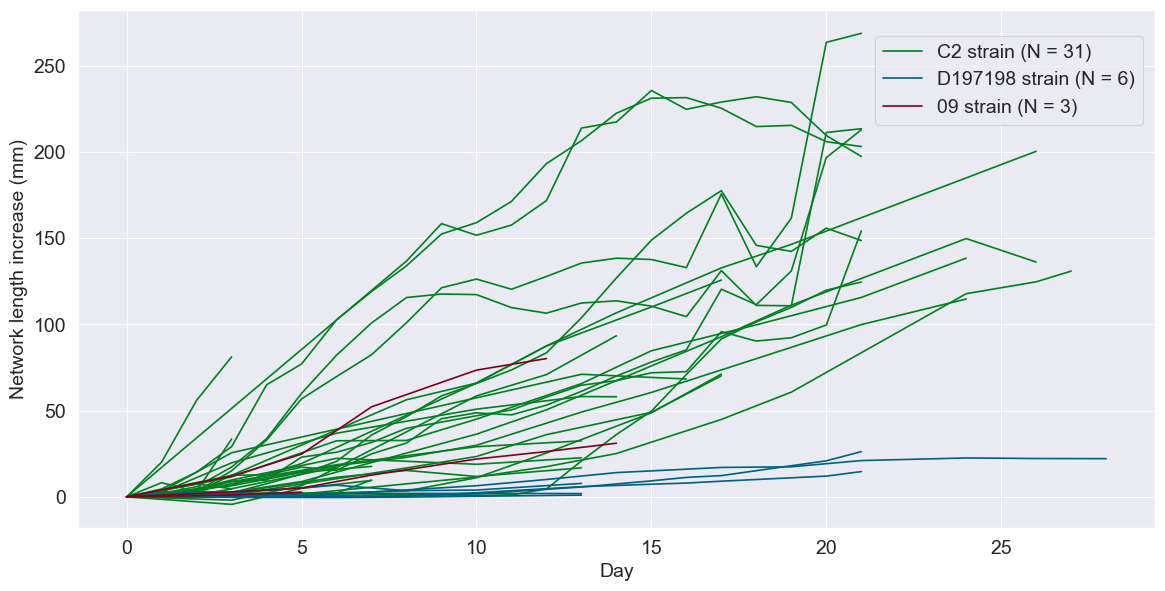

In [10]:
#Add strain column to data and combine
df_filtered["strain"] = "C2 strain"
df_filtered_D197198["strain"] = "D197198 strain"
df_filtered_09["strain"] = "09 strain"
df_all = pd.concat([df_filtered, df_filtered_D197198, df_filtered_09])

plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")
sns.set_context("paper", rc={"xtick.labelsize":14, "ytick.labelsize":14})

sns.lineplot(
    x="day",
    y="length_increase_mm",
    data=df_all,
    hue="strain",    
    units="id",        
    estimator=None,    
    palette={         
        "C2 strain": "#008020",
        "D197198 strain": "#006080",
        "09 strain": "#800020"
    }
)



plt.xlabel("Day",
          fontsize = 14)
plt.ylabel("Network length increase (mm)",
          fontsize = 14)
handles, _ = plt.gca().get_legend_handles_labels()

plt.legend(
    handles,
    ["C2 strain (N = 31)", "D197198 strain (N = 6)", "09 strain (N = 3)"],
    borderaxespad=0,
    bbox_to_anchor=(0.74,0.95),
    fontsize=14,
)

plt.tight_layout()
plt.savefig("Network_increase_all_mm", dpi=300,bbox_inches='tight', pad_inches=0)
plt.show()


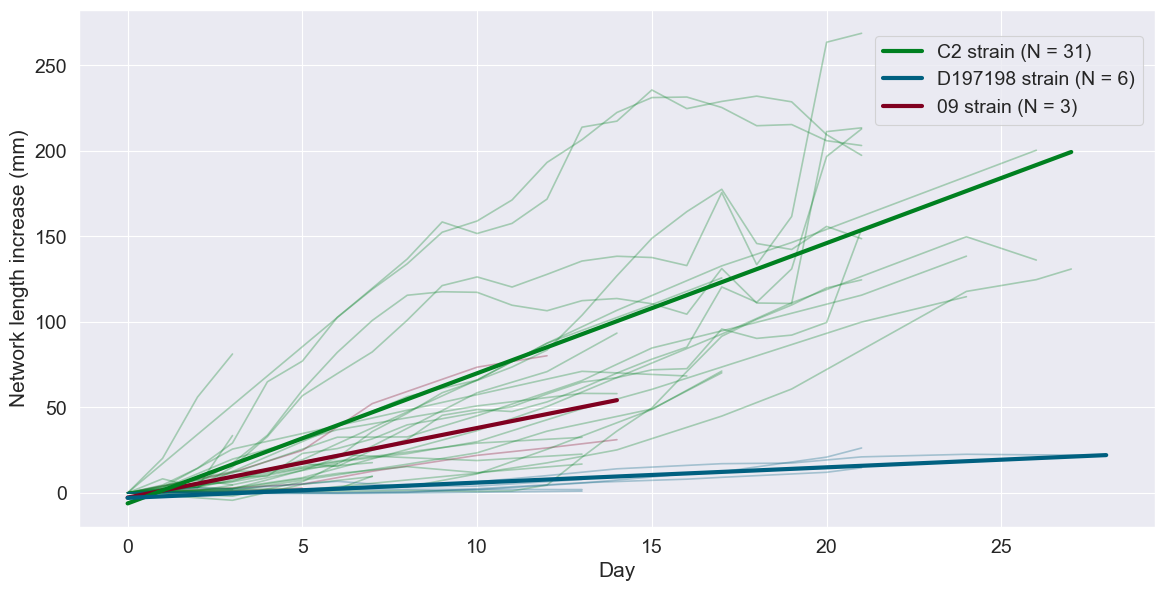

09 strain: slope = 4.070, R² = 0.502
C2 strain: slope = 7.614, R² = 0.589
D197198 strain: slope = 0.894, R² = 0.785


In [11]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")
sns.set_context("paper", rc={"xtick.labelsize":14, "ytick.labelsize":14})

# Define colors for each strain
colors = {
    "C2 strain": "#008020",
    "D197198 strain": "#006080",
    "09 strain": "#800020"
}

# Plot all individual replicates as light lines
for strain, group in df_all.groupby("strain"):
    for uid, sub in group.groupby("id"):
        plt.plot(sub["day"], sub["length_increase_mm"], color=colors[strain], alpha=0.3)

# Plot linear regression per strain
for strain, group in df_all.groupby("strain"):
    X = group["day"].values.reshape(-1,1)
    y = group["length_increase_mm"].values
    model = LinearRegression().fit(X, y)
    y_fit = model.predict(X)
    sorted_idx = np.argsort(X.flatten())
    plt.plot(X.flatten()[sorted_idx], y_fit[sorted_idx], color=colors[strain], linewidth=3)

plt.xlabel("Day", fontsize=15)
plt.ylabel("Network length increase (mm)", fontsize=15)

# --- Reuse same legend labels as first plot ---
handles = [
    plt.Line2D([], [], color=colors["C2 strain"], linewidth=3),
    plt.Line2D([], [], color=colors["D197198 strain"], linewidth=3),
    plt.Line2D([], [], color=colors["09 strain"], linewidth=3)
]

labels = ["C2 strain (N = 31)", "D197198 strain (N = 6)", "09 strain (N = 3)"]

plt.legend(
    handles,
    labels,
    borderaxespad=0,
    bbox_to_anchor=(0.74,0.95),
    fontsize=14
)

plt.tight_layout()
plt.savefig("Network_increase_all_mm_fit", dpi=300,bbox_inches='tight', pad_inches=0)
plt.show()

for strain, group in df_all.groupby("strain"):
    X = group["day"].values.reshape(-1,1)
    y = group["length_increase_mm"].values
    
    # Fit linear regression
    model = LinearRegression().fit(X, y)
    
    # Get slope (coefficient) and intercept
    slope = model.coef_[0]
    intercept = model.intercept_
    
    # Predict y values
    y_fit = model.predict(X)
    
    # Calculate R squared
    r2 = r2_score(y, y_fit)
    
    print(f"{strain}: slope = {slope:.3f}, R² = {r2:.3f}")

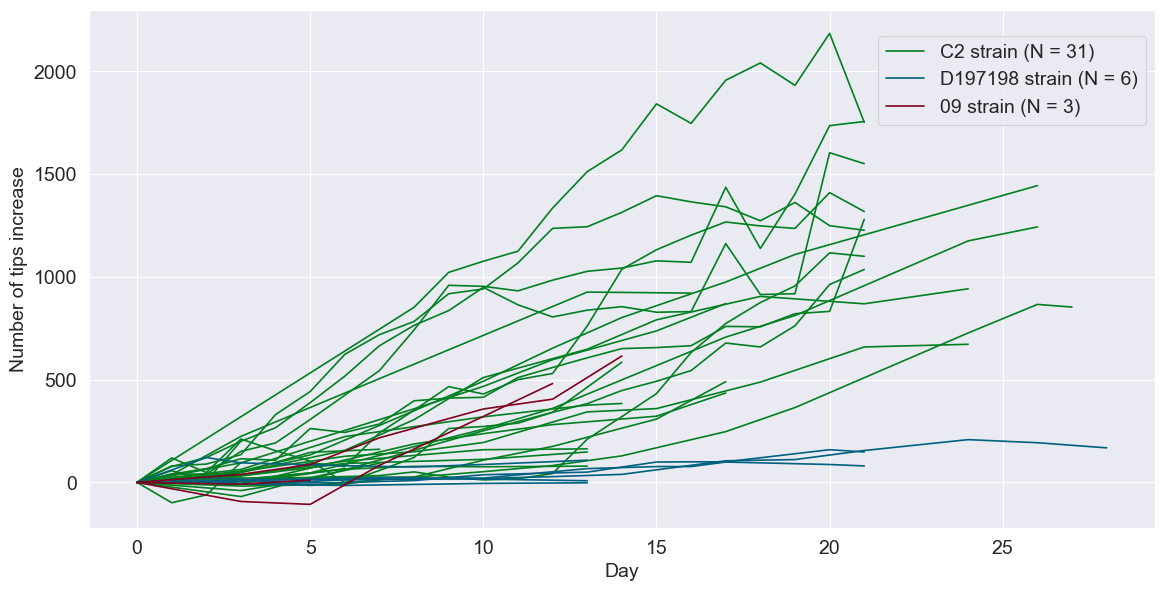

In [12]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")
sns.set_context("paper", rc={"xtick.labelsize":14, "ytick.labelsize":14})

sns.lineplot(
    x="day",
    y="tips_increase",
    data=df_all,
    hue="strain",    
    units="id",        
    estimator=None,    
    palette={         
        "C2 strain": "#008020",
        "D197198 strain": "#006080",
        "09 strain": "#800020"
    }
)

plt.xlabel("Day",
          fontsize = 14)
plt.ylabel("Number of tips increase",
          fontsize = 14)
handles, _ = plt.gca().get_legend_handles_labels()

plt.legend(
    handles,
    ["C2 strain (N = 31)", "D197198 strain (N = 6)", "09 strain (N = 3)"],
    borderaxespad=0,
    bbox_to_anchor=(0.74,0.95),
    fontsize=14,
)

plt.tight_layout()
plt.savefig("Tips_increase_all", dpi=300,bbox_inches='tight', pad_inches=0)
plt.show()

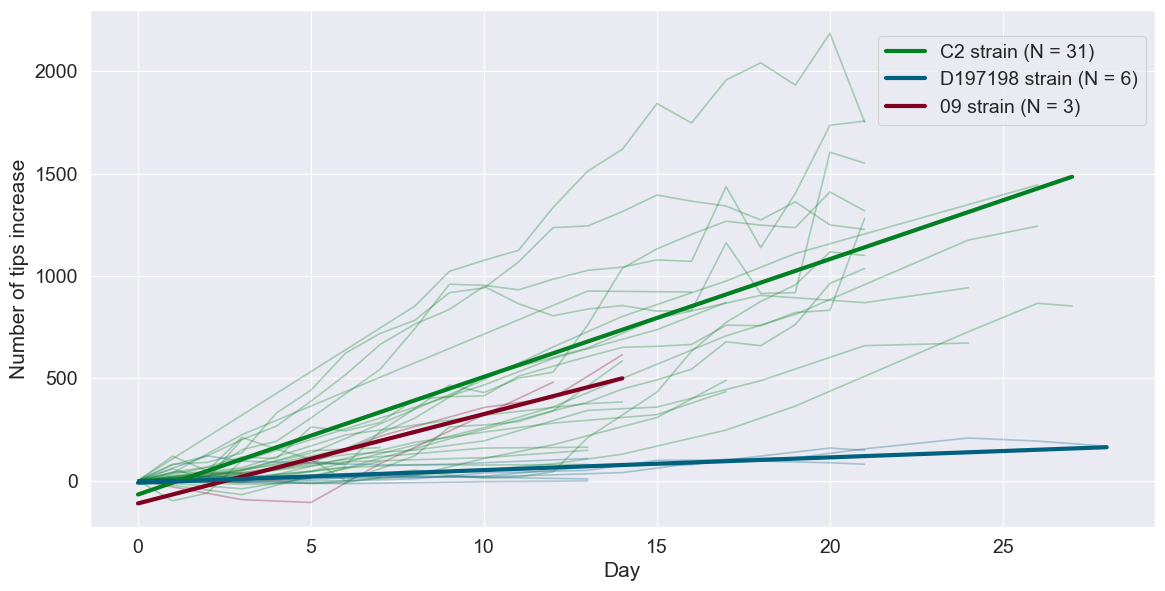

09 strain: slope = 43.656, R² = 0.809
C2 strain: slope = 57.492, R² = 0.611
D197198 strain: slope = 6.210, R² = 0.630


In [13]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")
sns.set_context("paper", rc={"xtick.labelsize":14, "ytick.labelsize":14})

# Define colors for each strain
colors = {
    "C2 strain": "#008020",
    "D197198 strain": "#006080",
    "09 strain": "#800020"
}

# Plot all individual replicates as light lines
for strain, group in df_all.groupby("strain"):
    for uid, sub in group.groupby("id"):
        plt.plot(sub["day"], sub["tips_increase"], color=colors[strain], alpha=0.3)

# Plot linear regression per strain
for strain, group in df_all.groupby("strain"):
    X = group["day"].values.reshape(-1,1)
    y = group["tips_increase"].values
    model = LinearRegression().fit(X, y)
    y_fit = model.predict(X)
    sorted_idx = np.argsort(X.flatten())
    plt.plot(X.flatten()[sorted_idx], y_fit[sorted_idx], color=colors[strain], linewidth=3)

plt.xlabel("Day", fontsize=15)
plt.ylabel("Number of tips increase", fontsize=15)

# --- Reuse same legend labels as first plot ---
handles = [
    plt.Line2D([], [], color=colors["C2 strain"], linewidth=3),
    plt.Line2D([], [], color=colors["D197198 strain"], linewidth=3),
    plt.Line2D([], [], color=colors["09 strain"], linewidth=3)
]

labels = ["C2 strain (N = 31)", "D197198 strain (N = 6)", "09 strain (N = 3)"]

plt.legend(
    handles,
    labels,
    borderaxespad=0,
    bbox_to_anchor=(0.74,0.95),
    fontsize=14
)

plt.tight_layout()
plt.savefig("Tips_increase_all_fit", dpi=300,bbox_inches='tight', pad_inches=0)
plt.show()

for strain, group in df_all.groupby("strain"):
    X = group["day"].values.reshape(-1,1)
    y = group["tips_increase"].values
    
    # Fit linear regression
    model = LinearRegression().fit(X, y)
    
    # Get slope (coefficient) and intercept
    slope = model.coef_[0]
    intercept = model.intercept_
    
    # Predict y values
    y_fit = model.predict(X)
    
    # Calculate R squared
    r2 = r2_score(y, y_fit)
    
    print(f"{strain}: slope = {slope:.3f}, R² = {r2:.3f}")

## C2 only

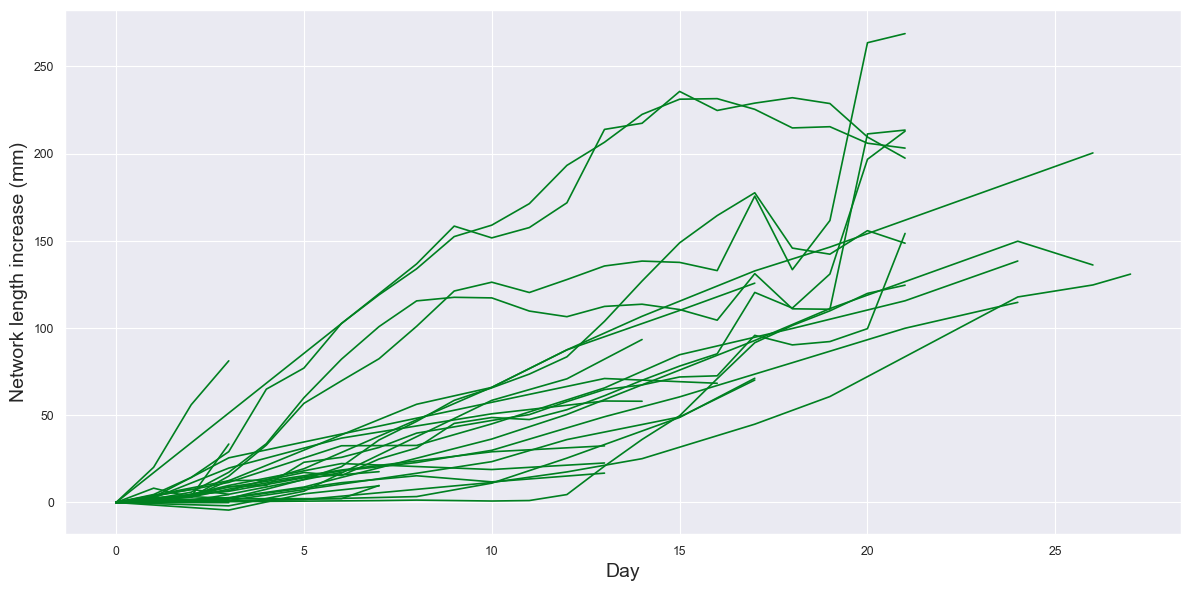

In [14]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")
sns.set_context("paper")

sns.lineplot(
    x="day",
    y="length_increase_mm",
    data=df_filtered,
    hue="strain",    
    units="id",        
    estimator=None,    
    palette={         
        "C2 strain": "#008020",
        "D197198 strain": "#006080",
        "09 strain": "#800020"
    },
    legend=False
)



plt.xlabel("Day",
          fontsize = 14)
plt.ylabel("Network length increase (mm)",
          fontsize = 14)


plt.tight_layout()
plt.savefig("Network_increase_C2_mm", dpi=300,bbox_inches='tight', pad_inches=0)
plt.show()


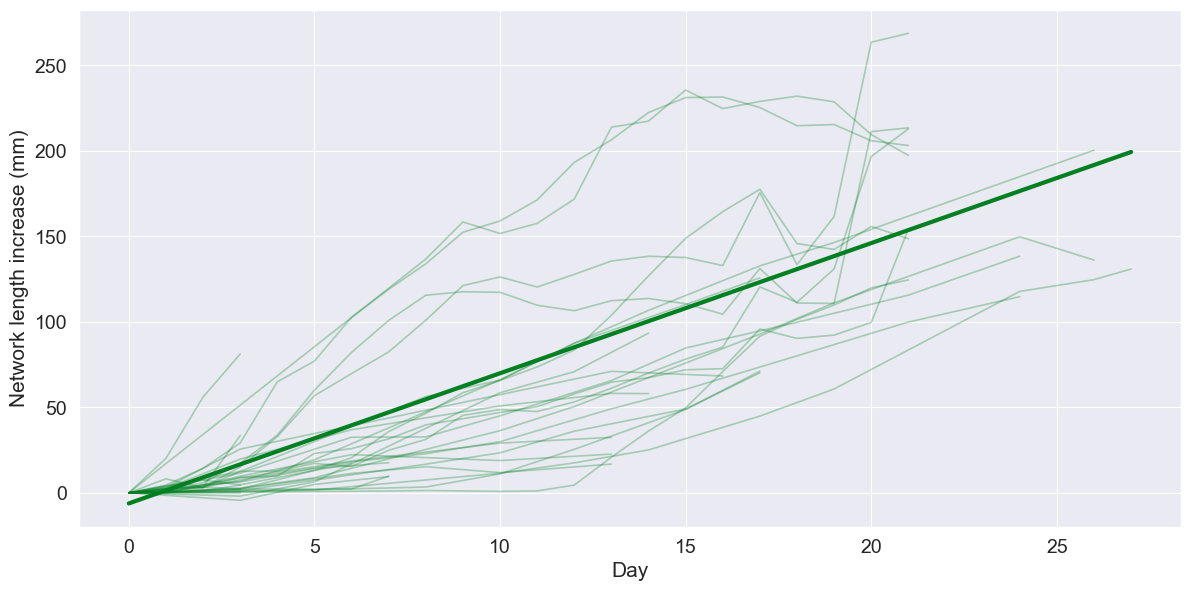

C2 strain: slope = 7.614, R² = 0.589


In [15]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")
sns.set_context("paper", rc={"xtick.labelsize":14, "ytick.labelsize":14})

# Define colors for each strain
colors = {
    "C2 strain": "#008020",
    "D197198 strain": "#006080",
    "09 strain": "#800020"
}

# Plot all individual replicates as light lines
for strain, group in df_filtered.groupby("strain"):
    for uid, sub in group.groupby("id"):
        plt.plot(sub["day"], sub["length_increase_mm"], color=colors[strain], alpha=0.3)

# Plot linear regression per strain
for strain, group in df_filtered.groupby("strain"):
    X = group["day"].values.reshape(-1,1)
    y = group["length_increase_mm"].values
    model = LinearRegression().fit(X, y)
    y_fit = model.predict(X)
    # Sort for clean line plotting
    sorted_idx = np.argsort(X.flatten())
    plt.plot(X.flatten()[sorted_idx], y_fit[sorted_idx], color=colors[strain], linewidth=3, label=f"{strain} fit")

plt.xlabel("Day", fontsize=15)
plt.ylabel("Network length increase (mm)", fontsize=15)

plt.tight_layout()
plt.savefig("Network_increase_C2_mm_fit", dpi=300,bbox_inches='tight', pad_inches=0)
plt.show()

for strain, group in df_filtered.groupby("strain"):
    X = group["day"].values.reshape(-1,1)
    y = group["length_increase_mm"].values
    
    # Fit linear regression
    model = LinearRegression().fit(X, y)
    
    # Get slope (coefficient) and intercept
    slope = model.coef_[0]
    intercept = model.intercept_
    
    # Predict y values
    y_fit = model.predict(X)
    
    # Calculate R squared
    r2 = r2_score(y, y_fit)
    
    print(f"{strain}: slope = {slope:.3f}, R² = {r2:.3f}")

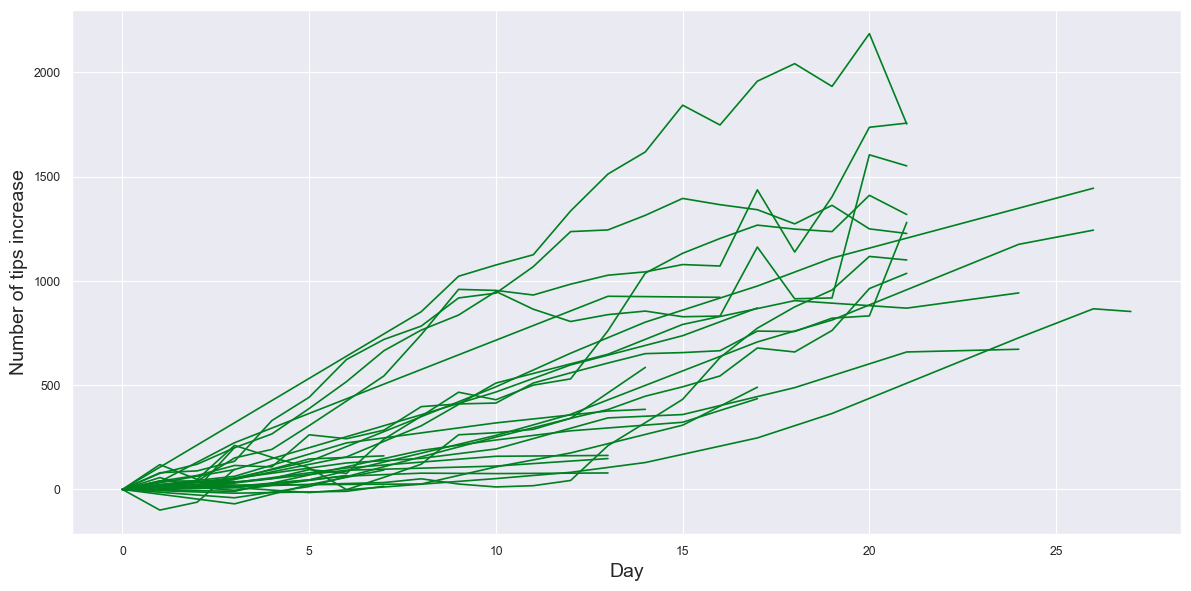

In [16]:
#Add strain column to data and combine
df_filtered["strain"] = "C2 strain"
df_filtered_D197198["strain"] = "D197198 strain"
df_filtered_09["strain"] = "09 strain"
df_all = pd.concat([df_filtered, df_filtered_D197198, df_filtered_09])

plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")
sns.set_context("paper")

sns.lineplot(
    x="day",
    y="tips_increase",
    data=df_filtered,
    hue="strain",    
    units="id",        
    estimator=None,    
    palette={         
        "C2 strain": "#008020",
        "D197198 strain": "#006080",
        "09 strain": "#800020"
    },
    legend=False
)



plt.xlabel("Day",
          fontsize = 14)
plt.ylabel("Number of tips increase",
          fontsize = 14)


plt.tight_layout()
plt.savefig("Number of tips increase_C2", dpi=300,bbox_inches='tight', pad_inches=0)
plt.show()


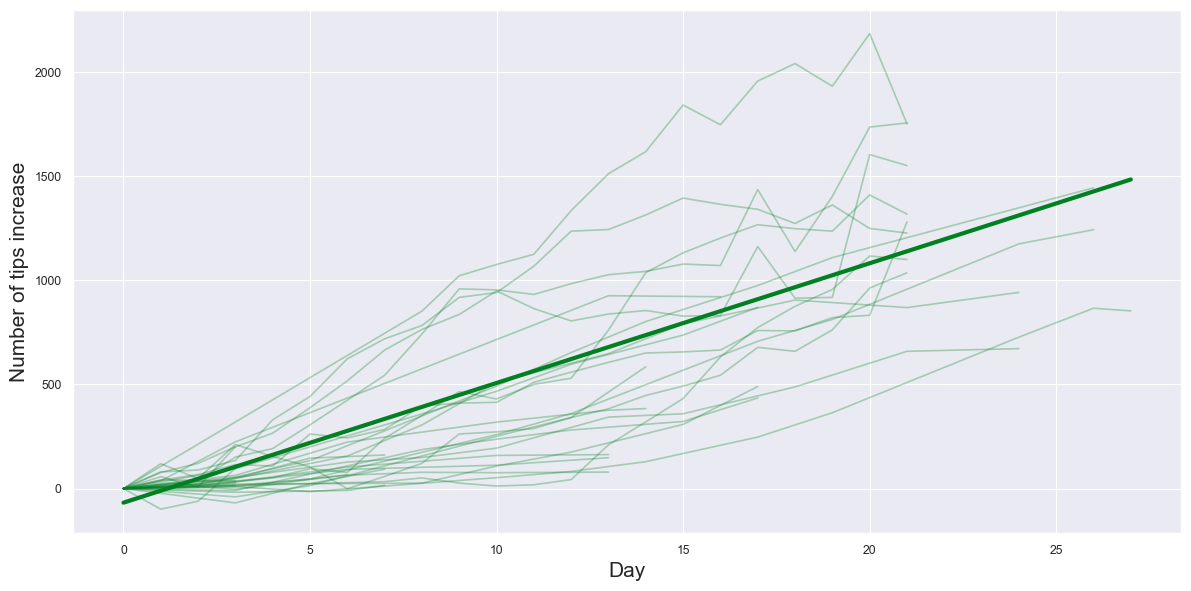

C2 strain: slope = 57.492, R² = 0.611


In [17]:
plt.figure(figsize=(12,6))
sns.set_theme(style="darkgrid")
sns.set_context("paper")

# Define colors for each strain
colors = {
    "C2 strain": "#008020",
    "D197198 strain": "#006080",
    "09 strain": "#800020"
}

# Plot all individual replicates as light lines
for strain, group in df_filtered.groupby("strain"):
    for uid, sub in group.groupby("id"):
        plt.plot(sub["day"], sub["tips_increase"], color=colors[strain], alpha=0.3)

# Plot linear regression per strain
for strain, group in df_filtered.groupby("strain"):
    X = group["day"].values.reshape(-1,1)
    y = group["tips_increase"].values
    model = LinearRegression().fit(X, y)
    y_fit = model.predict(X)
    # Sort for clean line plotting
    sorted_idx = np.argsort(X.flatten())
    plt.plot(X.flatten()[sorted_idx], y_fit[sorted_idx], color=colors[strain], linewidth=3, label=f"{strain} fit")

plt.xlabel("Day", fontsize=15)
plt.ylabel("Number of tips increase", fontsize=15)


plt.tight_layout()
plt.savefig("Tips_increase_C2_fit", dpi=300,bbox_inches='tight', pad_inches=0)
plt.show()

for strain, group in df_filtered.groupby("strain"):
    X = group["day"].values.reshape(-1,1)
    y = group["tips_increase"].values
    
    # Fit linear regression
    model = LinearRegression().fit(X, y)
    
    # Get slope (coefficient) and intercept
    slope = model.coef_[0]
    intercept = model.intercept_
    
    # Predict y values
    y_fit = model.predict(X)
    
    # Calculate R squared
    r2 = r2_score(y, y_fit)
    
    print(f"{strain}: slope = {slope:.3f}, R² = {r2:.3f}")

## Branch and tip data (not used)

In [19]:
#Cleaning of all_branches_um and tips_lengths_um. (Import issue?)
df_clean = df_all.copy()

# --- Cleaning functions ---
def clean_branches(val):
    """Clean branch lengths (list-like strings or arrays)."""
    if isinstance(val, (list, np.ndarray)):
        return list(val)
    if isinstance(val, str):
        cleaned = re.sub(r'np\.float64\(([^)]+)\)', r'\1', val)
        try:
            return ast.literal_eval(cleaned)  # should give list
        except Exception:
            return []
    return []

def clean_tips(val):
    """Clean tip lengths (semicolon-separated string)."""
    if isinstance(val, (list, np.ndarray)):
        return list(val)
    if isinstance(val, str):
        try:
            return [float(x) for x in val.split(";") if x.strip() != ""]
        except Exception:
            return []
    return []

# --- Apply cleaning ---
df_clean["branch_lengths"] = df_clean["all_branches_lengths_um"].apply(clean_branches)
df_clean["tips_lengths"]   = df_clean["tips_lengths_um"].apply(clean_tips)

In [20]:
print("clean df:")
print(df_test.head())

test df:
   day number of tips  total_length_um  \
0    0             62      2958.196640   
1    7             95      4038.238383   
2    8            113      4324.941412   
3    9             88      4064.542537   
4   10             74      3798.678944   

                             all_branches_lengths_um  tips_total_length_um  \
0  [4.628660713424565, 29.946556208168246, 42.366...           1171.390816   
1  [39.06712312508046, 45.27712312508046, 54.5344...           1537.901909   
2  [4.14, 6.209999999999999, 10.349999999999998, ...           1454.073533   
3  [93.95130612468262, 140.51320130279984, 174.61...           1499.592330   
4  [94.4940360628142, 138.67923299037753, 175.570...           1313.428043   

                                     tips_lengths_um  other_total_length_um  \
0  4.628660713424565;25.31789549474368;12.4199999...            1786.805823   
1  39.06712312508046;24.92610077810005;17.8068133...            2500.336474   
2  4.14;2.07;4.14;8.28;4.14;4.14

In [20]:
# Exploding of branch_lengths and tips_lengths so its not a list
df_branches = (
    df_clean[["day","branch_lengths"]]
    .explode("branch_lengths")
    .assign(branch_lengths=lambda d: pd.to_numeric(d["branch_lengths"], errors="coerce"))
    .dropna(subset=["branch_lengths"])
)

df_tips = (
    df_clean[["day","tips_lengths"]]
    .explode("tips_lengths")
    .assign(tips_lengths=lambda d: pd.to_numeric(d["tips_lengths"], errors="coerce"))
    .dropna(subset=["tips_lengths"])
)

print("Branches long df:")
print(df_branches.head())

print("Tips long df:")
print(df_tips.head())


Branches long df:
   day  branch_lengths
0    0        4.628661
0    0       29.946556
0    0       42.366556
0    0       54.957875
0    0      113.149991
Tips long df:
   day  tips_lengths
0    0      4.628661
0    0     25.317895
0    0     12.420000
0    0     58.192116
0    0     20.814647


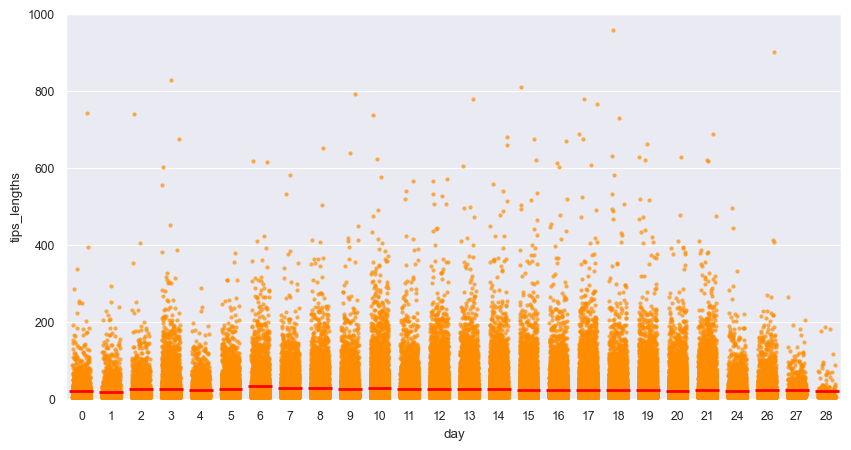

In [21]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.stripplot(
    data=df_tips,
    x="day", y="tips_lengths",
    color="darkorange",
    dodge=True,
    size=3,
    jitter=0.3,
    alpha=0.7,
    ax=ax
)

sns.boxplot(
    data=df_tips,
    x="day", y="tips_lengths",
    showmeans=True,
    meanline=True,
    meanprops={"color": "red", "ls": "-", "lw": 2},
    medianprops={"visible": False},
    whiskerprops={"visible": False},
    showfliers=False,
    showcaps=False,
    boxprops={"visible": False},
    ax=ax,
    zorder=10
)

ax.set_ylim(0, 1000)

plt.show()


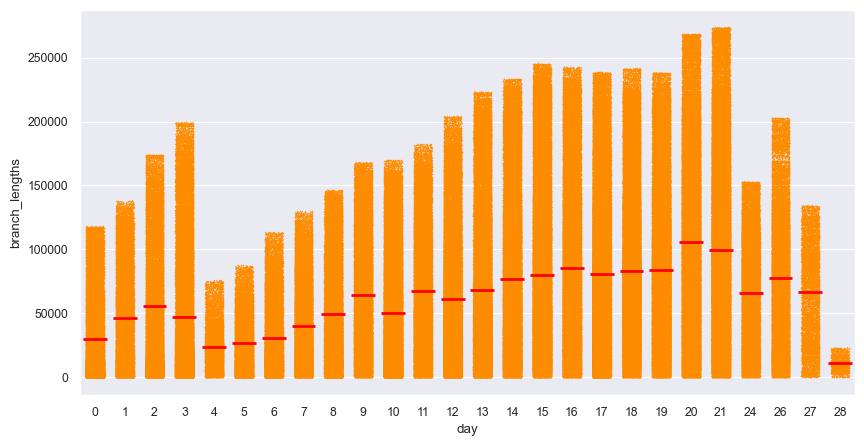

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.stripplot(
    data=df_branches,
    x="day", y="branch_lengths",
    color="darkorange",
    dodge=True,
    size=1,
    jitter=0.3,
    alpha=0.7,
    ax=ax
)

sns.boxplot(
    data=df_branches,
    x="day", y="branch_lengths",
    showmeans=True,
    meanline=True,
    meanprops={"color": "red", "ls": "-", "lw": 2},
    medianprops={"visible": False},
    whiskerprops={"visible": False},
    showfliers=False,
    showcaps=False,
    boxprops={"visible": False},
    ax=ax,
    zorder=10
)

plt.show()
